# EDA

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

In [2]:
DATA_FOLDER_PATH = Path("../../data")
PROCESSED_DATA_FOLDER_PATH = DATA_FOLDER_PATH.joinpath("processed")

## 1. Papers and affiliations

In [25]:
papers_df = pd.read_csv(PROCESSED_DATA_FOLDER_PATH.joinpath("papers.csv"))

In [26]:
paper_to_affiliation_df = pd.read_csv(PROCESSED_DATA_FOLDER_PATH.joinpath("paper_to_affiliation.csv"))

In [27]:
affiliation_count_df = paper_to_affiliation_df.groupby("paper_id")["id"].count().reset_index(name="affiliation_count")

In [29]:
papers_df = papers_df.merge(affiliation_count_df, left_on="id", right_on="paper_id", right_index=False, how="left")

In [30]:
papers_df["affiliation_count"] = papers_df["affiliation_count"].fillna(0)

<Axes: ylabel='Count'>

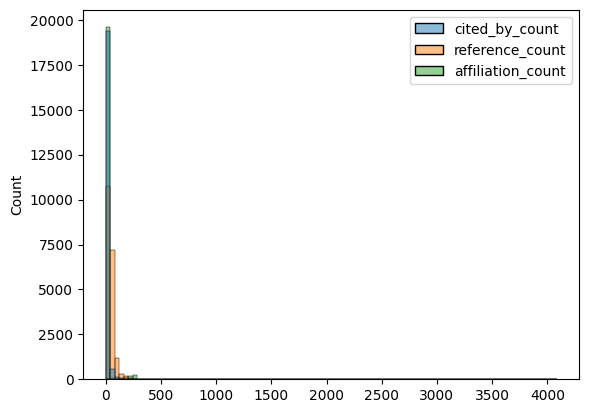

In [33]:
sns.histplot(papers_df, bins=100)

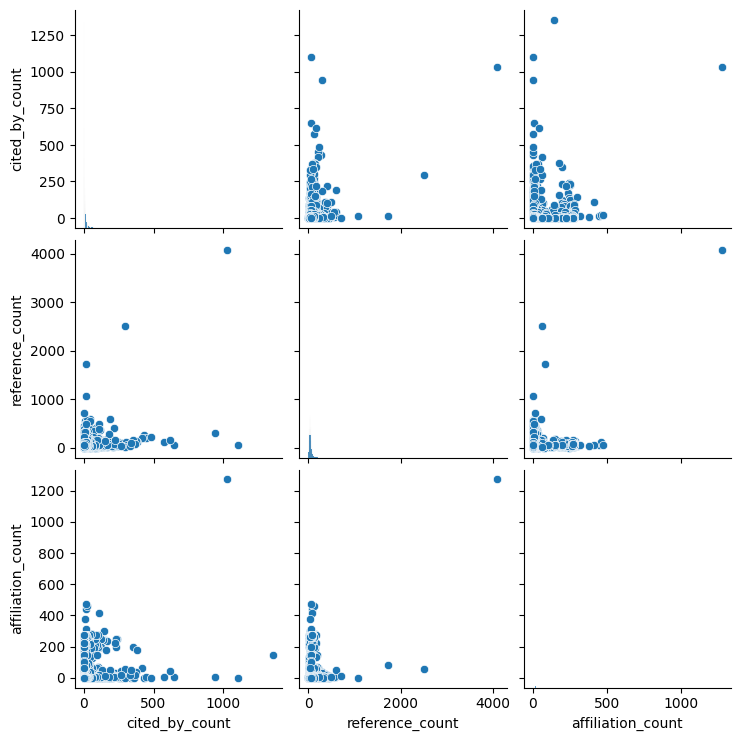

In [31]:
sns.pairplot(papers_df)

<Axes: >

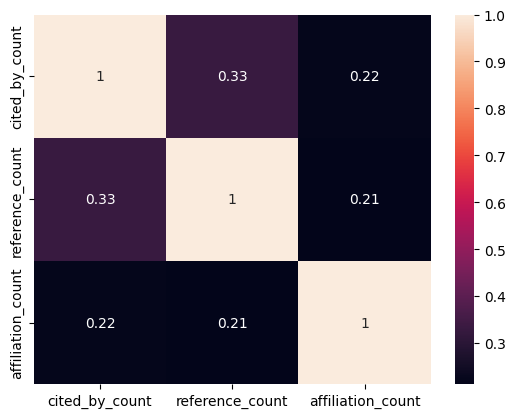

In [35]:
sns.heatmap(papers_df.select_dtypes(include="number").corr(), annot=True)

## 2. Classification codes

In [144]:
classification_codes_df = pd.read_csv(PROCESSED_DATA_FOLDER_PATH.joinpath("classification_codes.csv"))

In [147]:
classification_codes_df

,name,code,abbreviation
0,Medicine (all),2700,MEDI
1,Electrical and Electronic Engineering,2208,ENGI
2,"Electronic, Optical and Magnetic Materials",2504,MATE
3,Chemistry (all),1600,CHEM
4,Chemical Engineering (all),1500,CENG
...,...,...,...
316,Dental Assisting,3502,DENT
317,Gender Studies,3318,SOCI
318,Occupational Therapy,3609,HEAL
319,Optometry,3610,HEAL


<Axes: xlabel='count', ylabel='abbreviation'>

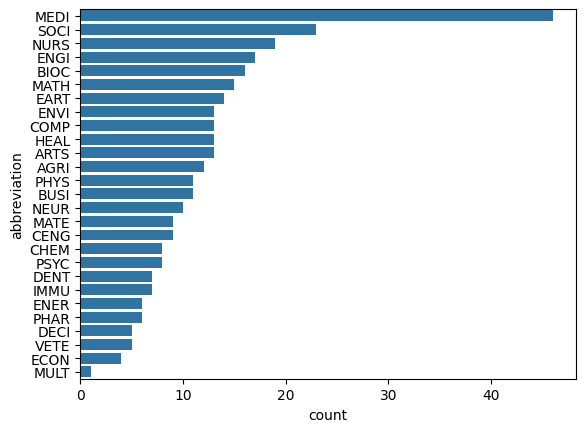

In [149]:
abbreviation_count_df = classification_codes_df.groupby("abbreviation")["code"].count().sort_values(ascending=False).reset_index(name="count")
sns.barplot(x="count", y="abbreviation", data=abbreviation_count_df)

## 3. Keyword co-occurrences

In [3]:
import networkx as nx

In [32]:
paper_to_keyword_df = pd.read_csv(PROCESSED_DATA_FOLDER_PATH.joinpath("paper_to_keyword.csv")).dropna()
paper_to_keyword_df.head(5)

,id,keyword
0,2-s2.0-85052201238,Multiphase flow models
1,2-s2.0-85052201238,Riser
2,2-s2.0-85052201238,Sorption enhanced steam methane reforming
3,2-s2.0-85052201238,Encapsulation
4,2-s2.0-85052201238,Fluoroalkylsilane


In [33]:
keyword_count_df = paper_to_keyword_df.groupby("keyword").count().sort_values(by="id", ascending=False)
keyword_count_df.head(5)

,id
keyword,
Thailand,713
COVID-19,268
Hadron-Hadron scattering (experiments),136
Inflammation,121
HIV,110


In [34]:
keyword_groups = paper_to_keyword_df.groupby("id")["keyword"].apply(list)
keyword_groups.head(5)

id
2-s2.0-84946771902    [thioesterase domain, Adrenal gland volume, fo...
2-s2.0-84946882107    [Synergistic effects, Botulinum toxin therapy,...
2-s2.0-84957541768    [Magneto-electronics, recording head, tunnelin...
2-s2.0-84963739401    [Hydroxyl terminated natural rubber, Poly(lact...
2-s2.0-84973402286    [Thailand, Work-related musculoskeletal disord...
Name: keyword, dtype: object

In [61]:
G = nx.Graph()

for keyword_group in keyword_groups:
    keyword_group = [keyword.lower() for keyword in keyword_group]
    G.add_nodes_from(keyword_group)
    for idx1, keyword1 in enumerate(keyword_group):
        for idx2, keyword2 in enumerate(keyword_group[idx1+1:], idx1+1):
            if G.has_edge(keyword1, keyword2):
                G[keyword1][keyword2]["weight"] += 1
            else:
                G.add_edge(keyword1, keyword2, weight=1)

In [62]:
keyword_to_degree = pd.Series(dict(G.degree())).sort_values(ascending=False)
keyword_to_degree.head(5)

thailand            2674
covid-19            1066
machine learning     544
inflammation         503
sars-cov-2           439
dtype: int64

<Axes: ylabel='None'>

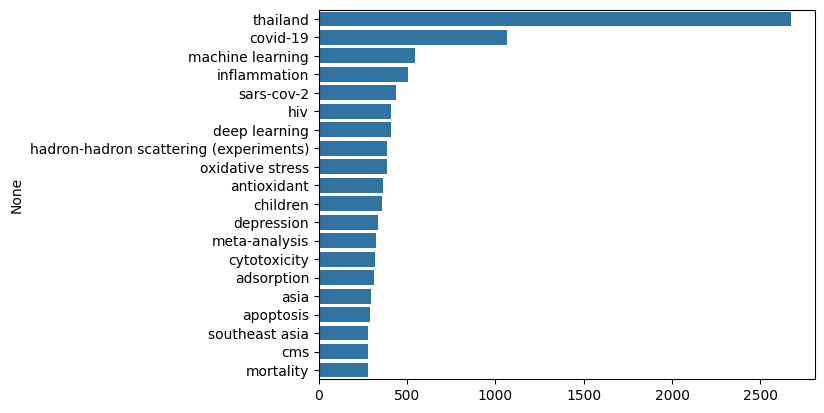

In [63]:
sns.barplot(x=keyword_to_degree.head(20).values, y=keyword_to_degree.head(20).index)

In [64]:
keyword_pagerank_centralities = pd.DataFrame.from_dict(
    nx.pagerank(G), orient="index", columns=["pagerank_centrality"]
).sort_values("pagerank_centrality", ascending=False)
keyword_pagerank_centralities.head(5)

,pagerank_centrality
thailand,0.006924
covid-19,0.002662
inflammation,0.001404
machine learning,0.001347
deep learning,0.001054


In [65]:
communities = nx.community.louvain_communities(G, weight="weight", seed=56164)
communities

[{'adrenal gland volume',
  'foetal zone enlargement',
  'placental alpha microglobulin-1',
  'thioesterase domain'},
 {"pharmacist's care",
  'duck farms',
  'lactoferrin',
  'acute myeloid leukemia with antecedent hematological disease',
  'graphene nanoplatelets',
  'hplc-pda',
  'multiple crisis',
  'parenchyma',
  'viewers response',
  'tetralogy of fallot',
  'capability',
  'healthy foods',
  'migrants',
  'emerging country',
  'savannakhet',
  'don sahong dam',
  'fur',
  'older persons',
  'insect',
  'globalization',
  'process modelling',
  'food choice',
  'maiduguri',
  'lutein',
  'quality management',
  'matching',
  'transpterygoid',
  'safety assessment',
  'daily gain',
  '0-essential fuzzy ideals',
  'community nurses',
  'potential vector',
  'theory of planned behaviour',
  'civil society',
  'binder free',
  'sustainability',
  'damnacanthal',
  'thai classical music',
  'arbitration',
  'corgi',
  'spinal pain',
  'intracaval tumor thrombus',
  'multicultural com

In [66]:
keyword_to_community = pd.DataFrame.from_dict({
    keyword: idx
    for idx, community in enumerate(communities)
    for keyword in community
}, orient="index", columns=["community"])

In [83]:
community_sum_pagerank_centralities = keyword_pagerank_centralities.join(keyword_to_community).reset_index(names=["keyword"]).groupby("community").agg(
    {"pagerank_centrality": "sum"}
).sort_values("pagerank_centrality", ascending=False)
community_sum_pagerank_centralities.head(10)

,pagerank_centrality
community,
1,0.054021
7,0.041228
110,0.040398
98,0.037817
38,0.025946
65,0.025842
818,0.025833
374,0.024489
749,0.024108


In [85]:
communities[65]

{'floral scent',
 'polypectomy',
 'ethnoprimatology',
 'klang valley',
 'bubble hydrodynamic',
 'mushroom cultivation',
 'micro-hardness',
 'scada',
 'zoonotic infections',
 'colour variation',
 'cytochrome b',
 'plant species',
 'fruit',
 'design thinking framework',
 'metaphire',
 'smartphone camera',
 'sundaland',
 'mountain forest',
 'uterine artery doppler',
 'fgfr2',
 'marine geitlerinema',
 'specialization',
 'friedman method',
 'people with visual disability',
 'blood screening',
 'endophytes',
 'molecular dating',
 'load economic model',
 'polyp',
 'paleoenvironment',
 'image enhancement',
 'mosquito salivary proteins',
 'serum micro-rna 210',
 'baff',
 'perioperative care',
 'scanning electron microscopy',
 'mitochondrial genes',
 'khok sung',
 'singular-plural forms',
 'poisoning attack',
 'pulsatility index',
 'coleoptera',
 'fluoridated milk',
 'sit-to-stand motion',
 'thalassemia trait',
 'water re-freeze',
 'personal income tax',
 'demagnetization',
 'nonparametric causa

In [78]:
x = keyword_pagerank_centralities.join(keyword_to_community).reset_index(names=["keyword"])
x.sort_values(["pagerank_centrality"], ascending=False).groupby("community").first().sort_values("pagerank_centrality", ascending=False).head(50)

,keyword,pagerank_centrality
community,,
1,thailand,0.006924
98,covid-19,0.002662
7,inflammation,0.001404
110,machine learning,0.001347
749,hadron-hadron scattering (experiments),0.001026
374,hiv,0.000966
818,antioxidant,0.000847
38,meta-analysis,0.000753
95,adsorption,0.000729
